# NVIDIA NIMs 

> [NVIDIA NIMs](https://ai.nvidia.com)为用户提供了访问NVIDIA托管的AI模型API端点的便捷方式，如Mixtral 8x22B、Llama 3、Stable Diffusion等。这些模型托管在[https://build.nvidia.com](https://build.nvidia.com)，经过优化、测试并托管在NVIDIA AI平台上，使其快速且易于评估，进一步定制，并在任何加速堆栈上无缝运行以实现最佳性能。
> 
> 使用[NVIDIA NIMs](https://ai.nvidia.com)，您可以从在[NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/)上运行的完全加速堆栈中快速获得结果。这些模型可以在任何地方部署，使用[NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/)提供企业级安全性、稳定性和支持。
> 
> 这些模型可以通过[`llama-index-embeddings-nvidia`](https://pypi.org/project/llama-index-embeddings-nvidia/)包轻松访问，如下所示。

本示例介绍了如何使用LlamaIndex与支持的[NVIDIA检索QA嵌入模型](https://build.nvidia.com/explore/retrieval)进行交互，以实现[检索增强生成](https://developer.nvidia.com/blog/build-enterprise-retrieval-augmented-generation-apps-with-nvidia-retrieval-qa-embedding-model/)，通过`NVIDIAEmbedding`类。


## 安装说明


In [ ]:
%pip install --upgrade --quiet llama-index-embeddings-nvidia

Note: you may need to restart the kernel to use updated packages.


注意：您可能需要重新启动内核才能使用更新后的包。


## 设置

**开始使用：**

1. 在[NVIDIA AI](https://build.nvidia.com/)服务上创建一个免费账户，该服务托管了AI解决方案目录、容器、模型等。

2. 转到任何模型并点击`获取API密钥`。

3. 将生成的密钥保存在您的环境中，命名为`NVIDIA_API_KEY`。从那里，您就可以访问端点了。


In [ ]:
import getpassimport os# del os.environ['NVIDIA_API_KEY']  ## 删除密钥并重置if os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):    print("有效的NVIDIA_API_KEY已存在于环境中。删除以重置")else:    api_key = getpass.getpass("NVIDIA API Key (以nvapi-开头): ")    assert api_key.startswith("nvapi-"), f"{api_key[:5]}... 不是一个有效的密钥"    os.environ["NVIDIA_API_KEY"] = api_key

## 初始化

在初始化嵌入模型时，您可以通过传递模型名称来选择模型，例如下面的 `NV-Embed-QA`，或者不传递任何参数来使用默认模型。


In [ ]:
from llama_index.embeddings.nvidia import NVIDIAEmbedding

embedder = NVIDIAEmbedding(model="NV-Embed-QA")

这个模型是一个经过微调的E5-large模型，支持预期的[`Embeddings`](https://docs.llamaindex.ai/en/stable/api_reference/embeddings/)方法，包括：

- `get_query_embedding`：为查询样本生成查询嵌入。

- `get_text_embedding_batch`：为您想要搜索的文档列表生成文本嵌入。

- 以及上述方法的异步版本。


### **相似度**

以下是对这些数据点相似度的快速测试：

**查询:**

- 堪察加的天气怎么样？

- 意大利以哪些食物而闻名？

- 我的名字是什么？我打赌你不记得……

- 生活的意义到底是什么？

- 生活的意义在于享受乐趣 :D

**文本:**

- 堪察加的天气寒冷，冬季漫长严寒。

- 意大利以意面、比萨、意式冰淇淋和浓缩咖啡而闻名。

- 我无法记住个人姓名，只能提供信息。

- 生活的目的各不相同，通常被视为个人的实现。

- 享受生活的时刻确实是一种美妙的方式。


### 嵌入查询

在使用嵌入式查询时，我们可以将查询嵌入到Python代码中，以便在代码中动态执行查询并获取结果。这种方法非常适合需要在代码中动态生成查询的情况，例如根据用户输入或其他条件构建查询。通过嵌入式查询，我们可以更灵活地处理数据，并根据需要动态调整查询逻辑。


In [ ]:
print("\nSequential Embedding: ")
q_embeddings = [
    embedder.get_query_embedding("What's the weather like in Komchatka?"),
    embedder.get_query_embedding("What kinds of food is Italy known for?"),
    embedder.get_query_embedding(
        "What's my name? I bet you don't remember..."
    ),
    embedder.get_query_embedding("What's the point of life anyways?"),
    embedder.get_query_embedding("The point of life is to have fun :D"),
]
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))


Sequential Embedding: 
Shape: (5, 1024)


### 文档嵌入

文档嵌入是指将文档转换为连续向量空间中的向量表示。这种表示方法可以捕捉文档的语义和语法信息，从而在自然语言处理任务中发挥重要作用。常见的文档嵌入方法包括词袋模型、TF-IDF、Word2Vec和Doc2Vec等。这些方法可以帮助计算机更好地理解和处理文本数据。


In [ ]:
print("\nBatch Document Embedding: ")
d_embeddings = embedder.get_text_embedding_batch(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
print("Shape:", (len(d_embeddings), len(d_embeddings[0])))


Batch Document Embedding: 
Shape: (5, 1024)


现在我们已经生成了嵌入向量，我们可以对结果进行简单的相似度检查，以查看在检索任务中哪些文档会被视为合理的答案：


In [ ]:
%pip install --upgrade --quiet matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


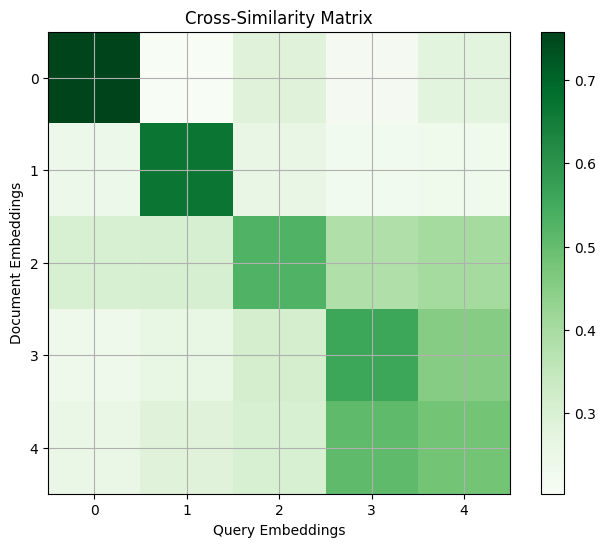

In [ ]:
import matplotlib.pyplot as pltimport numpy as npfrom sklearn.metrics.pairwise import cosine_similarity# 计算q_embeddings和d_embeddings之间的相似性矩阵cross_similarity_matrix = cosine_similarity(    np.array(q_embeddings),    np.array(d_embeddings),)# 绘制交叉相似性矩阵plt.figure(figsize=(8, 6))plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")plt.colorbar()plt.title("交叉相似性矩阵")plt.xlabel("查询嵌入")plt.ylabel("文档嵌入")plt.grid(True)plt.show()

作为提醒，发送到我们系统的查询和文档如下：

**查询:**

- 堪察加的天气如何？

- 意大利以哪些食物而闻名？

- 我的名字是什么？我打赌你不记得……

- 生命的意义到底是什么？

- 生命的意义在于享受乐趣 :D

**文本:**

- 堪察加的天气寒冷，冬季漫长严寒。

- 意大利以意面、比萨、意式冰淇淋和浓缩咖啡而闻名。

- 我无法回忆个人姓名，只能提供信息。

- 生命的目的各不相同，通常被视为个人的成就。

- 享受生活的时刻确实是一种美妙的方式。


## 截断

嵌入模型通常具有固定的上下文窗口，确定可以嵌入的最大输入标记数量。这个限制可以是一个硬限制，等于模型的最大输入标记长度，也可以是一个有效限制，在超过这个限制后，嵌入的准确性会降低。

由于模型操作的是标记，而应用通常使用文本，因此对于应用程序来说，确保其输入保持在模型的标记限制内可能是具有挑战性的。默认情况下，如果输入太大，会抛出异常。

为了帮助解决这个问题，NVIDIA NIMs提供了一个`truncate`参数，如果输入太大，服务器端会对其进行截断。

`truncate`参数有三个选项：
 - "NONE": 默认选项。如果输入太大，会抛出异常。
 - "START": 服务器从开头（左侧）截断输入，根据需要丢弃标记。
 - "END": 服务器从末尾（右侧）截断输入，根据需要丢弃标记。


In [ ]:
long_text = "AI is amazing, amazing is " * 100

In [ ]:
strict_embedder = NVIDIAEmbedding()
try:
    strict_embedder.get_query_embedding(long_text)
except Exception as e:
    print("Error:", e)

Error: Error code: 400 - {'type': 'urn:nvcf-worker-service:problem-details:bad-request', 'title': 'Bad Request', 'status': 400, 'detail': 'Inference error', 'instance': '/v2/nvcf/pexec/functions/09c64e32-2b65-4892-a285-2f585408d118', 'requestId': 'ccaac47c-a61e-4eba-abe8-dc7f254f52b2'}


In [ ]:
truncating_embedder = NVIDIAEmbedding(truncate="END")
truncating_embedder.get_query_embedding(long_text)[:5]

[-0.008758544921875,
 0.0009446144104003906,
 -0.035064697265625,
 0.0254058837890625,
 0.00414276123046875]

## 连接到本地的NIMs

除了连接到托管的[NVIDIA NIMs](https://ai.nvidia.com)之外，此连接器还可以用于连接到本地的微服务实例。这有助于在必要时将您的应用程序部署到本地。

有关设置本地微服务实例的说明，请参阅https://developer.nvidia.com/blog/nvidia-nim-offers-optimized-inference-microservices-for-deploying-ai-models-at-scale/


In [ ]:
from llama_index.embeddings.nvidia import NVIDIAEmbedding

llm = NVIDIAEmbedding().mode("nim", base_url="http://0.0.0.0:12345/v1")
llm.available_models

[Model(id='e5-small-v2')]